In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lec10_graphs as afx
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 6)
rep_seed = 11238

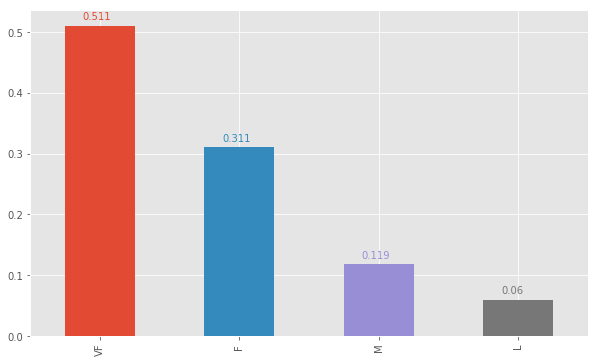

In [7]:
df = pd.read_csv('hpcjobschedule.csv').drop(columns='Unnamed: 0')
def annotated_barplot(var):
    tmp_values = var.value_counts('%')
    tmp_ax = tmp_values.plot(kind='bar')
    for index, p in enumerate(tmp_ax.patches):
        tmp_ax.annotate(tmp_values[index].round(3),xy=(p.get_x() + .125, p.get_height() + 0.01),color=p.get_facecolor())
        
annotated_barplot(df['Class'])

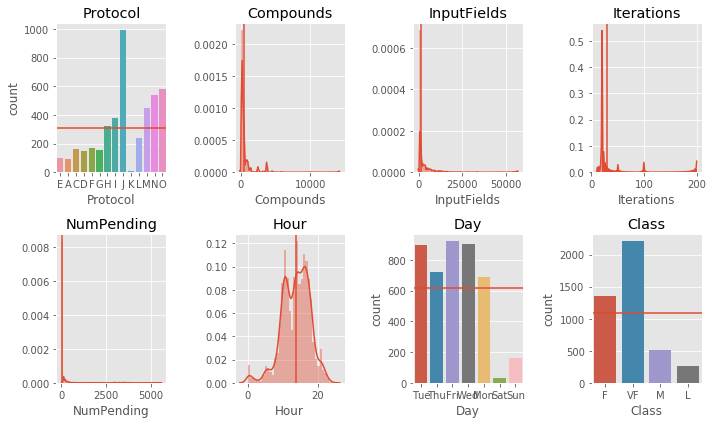

In [8]:
# definimos el dimensionado de nuestra grilla
rows= 2; cols = len(df.columns) // rows
# definimos el tamaño de la figura
afx.plot_describe_variables(df, rows=rows, cols=cols)

In [9]:
# Módulos de preprocesamiento
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
# Módulos de modelos
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [10]:
# recodificamos nuestro vector objetivo
df['very_fast'] = np.where(df['Class'] == 'VF', 1, 0)
# generamos un conjunto de variables binarias para Day y Protocol.
df = pd.concat([df,pd.get_dummies(df['Day'], drop_first=True)], axis=1)
df = pd.concat([df, pd.get_dummies(df['Protocol'], drop_first=True)], axis=1)
# Eliminamos las variables originales
df = df.drop(columns=['Protocol', 'Class', 'Day'])

In [11]:
log_vars = ['Compounds', 'InputFields', 'Iterations', 'NumPending']
for i in log_vars:
    df[i] = df[i].apply(lambda x: np.log(x +0.001))

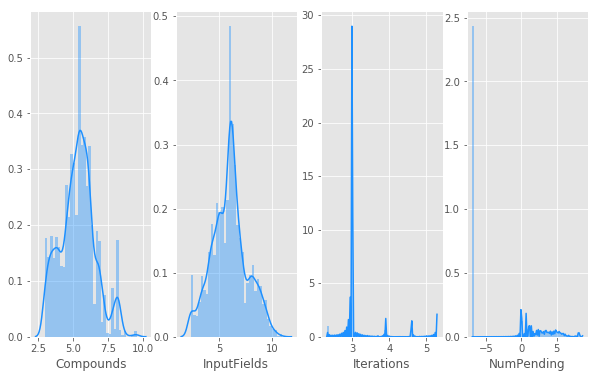

In [13]:
for index, value in enumerate(log_vars):
    plt.subplot(1, 4, index + 1)
    sns.distplot(df[value], color='dodgerblue')

In [15]:
# preservamos en una nueva variable nuestro vector objetivo
y = df.pop('very_fast')
# Generamos la separación entre muestra de evaluación y holdout
X_eval, X_holdout, y_eval, y_holdout = train_test_split(df, y, test_size=.33, random_state=rep_seed)
# Separamos la muestra de entrenamiento entre entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(X_eval, y_eval,test_size=.33, random_state=rep_seed)
print(f'Registros holdout: {X_holdout.shape[0]} / Atributos holdout: {X_holdout.shape[1]}')
print(f'Registros training: {X_train.shape[0]} / Atributos training: {X_train.shape[1]}')
print(f'Registros testing: {X_test.shape[0]} / Atributos holdout: {X_test.shape[1]}')

Registros holdout: 1430 / Atributos holdout: 24
Registros training: 1943 / Atributos training: 24
Registros testing: 958 / Atributos holdout: 24


In [19]:
# definimos el comité de clasificadores en una lista de tuplas
estimators = [('Linear Discriminant Analysis', LinearDiscriminantAnalysis()), 
              ('Logistic Regression', LogisticRegression(random_state=rep_seed)), 
              ('Decision Tree Classifier', DecisionTreeClassifier(random_state=rep_seed)), 
              ('Support Vector Classifier', SVC(kernel='linear',  random_state=rep_seed)), # para el caso de kmeans y GMM es necesario definir la cantidadde clusters a inferir
              ('Kmeans', KMeans(n_clusters=2, random_state=rep_seed)),
              ('Gaussian Mixture Model', GaussianMixture(n_components=2,random_state= rep_seed))]

In [20]:
estimators[4:]

[('Kmeans',
  KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
      n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
      random_state=11238, tol=0.0001, verbose=0)),
 ('Gaussian Mixture Model',
  GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
          means_init=None, n_components=2, n_init=1, precisions_init=None,
          random_state=11238, reg_covar=1e-06, tol=0.001, verbose=0,
          verbose_interval=10, warm_start=False, weights_init=None))]

KeyError: "['accuracy'] not found in axis"

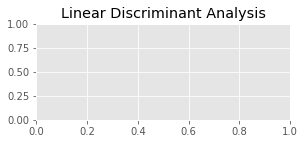

In [26]:
for index, value in enumerate(estimators):
    plt.subplot(3, 2, index + 1)
    plt.title(value[0])
    class_pred = value[1].fit(X_train, y_train).predict(X_test)
    afx.plot_classification_report(y_test, class_pred, dummy_class=True)
    plt.axvline(.5,label='.5 Boundary', linestyle='--')
    plt.xlim((0.1, 1.0))
    if (index + 1) % 2 == 0:
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()

In [27]:
# VotingClassifier requiere de la lista de tuplas que definimos arriba
voting_classifier = VotingClassifier(estimators).fit(X_train, y_train)

In [31]:
afx.plot_classification_report(y_test,voting_classifier.fit(X_train,y_train).predict(X_test), dummy_class=True)
plt.xlim((0.4, 1.0))
plt.title('Voting Classifier');
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

KeyError: "['accuracy'] not found in axis"

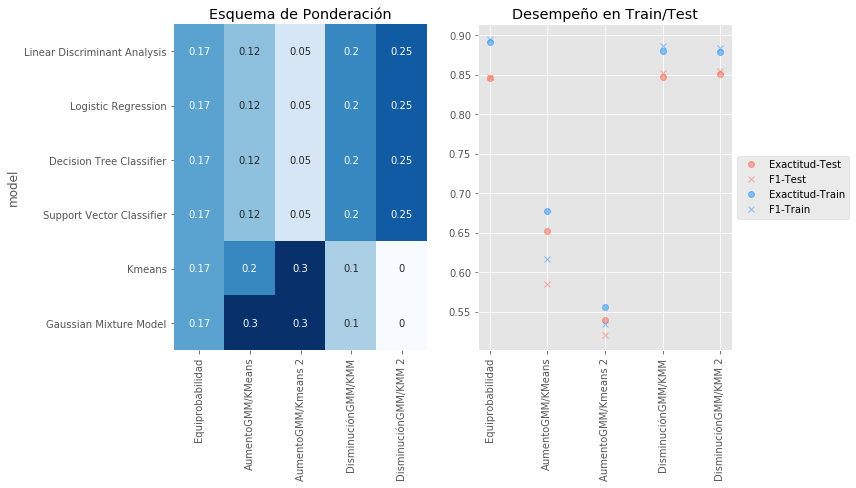

In [32]:
# definimos un diccionario con el esquema de ponderación a aplicar
weights_hyperparams = {'Equiprobabilidad': [.166, .166, .166, .166, .166,.166],
                       'AumentoGMM/KMeans': [.125, .125, .125, .125, .20, .30],
                       'AumentoGMM/Kmeans 2': [.05, .05, .05, .05, .30, .30],
                       'DisminuciónGMM/KMM':[.20, .20, .20, .20, .10, .10], 
                       'DisminuciónGMM/KMM 2': [.25, .25, .25, .25,.0, .0]}
# implementamos la evaluación del modelo
afx.weighting_schedule(voting_classifier, X_train, X_test, y_train, y_test,weights_hyperparams)

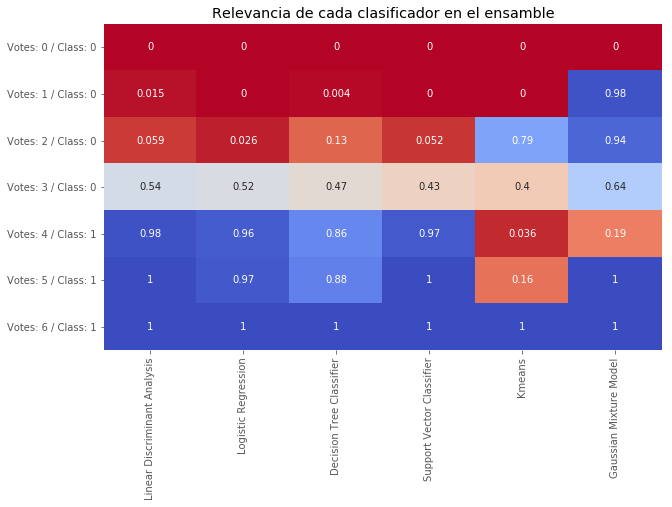

In [33]:
afx.committee_voting(voting_classifier, X_train, X_train, y_train, y_test)
plt.title('Relevancia de cada clasificador en el ensamble');